In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#добавляет строку - дата с момента первого дня жизни когорты
#нужно для того, чтобы при resample интерполировать данные за 90 для каждой когоры
#что в свою очередь необходимо для посчета ltv_90 за 90 дней по каждой когорте
def add_row(frame):
  day_90 = frame['pay_dt'].min() + pd.DateOffset(days=89)
  day_90 = pd.to_datetime(day_90).date()
  if frame['pay_dt'].max() < day_90:
    last_row = frame.iloc[-1]
    last_row['pay_dt'] = day_90
    last_row['payment_sum'] = 0
    return frame.append(last_row)
  return frame

#подготовка данных, ч-1
def merge_tables(profiles, payments):
  merged_table = pd.merge(profiles, payments, on="uid", how="left")
  merged_table['pay_dt'] = np.where(merged_table['pay_dt'].isnull(), merged_table['reg_dt'], merged_table['pay_dt'])
  merged_table['pay_dt'] = pd.to_datetime(merged_table['pay_dt']).dt.date
  merged_table['reg_dt'] = pd.to_datetime(merged_table['reg_dt']).dt.date
  merged_table['payment_sum'] = merged_table['payment_sum'].replace(np.nan, 0)
  
  merged_table = merged_table.assign(cohort_group = merged_table.groupby(level=0)['reg_dt'].min())
  merged_table.reset_index(drop=True, inplace=True)
  merged_table = merged_table.groupby('cohort_group').apply(add_row).reset_index(drop=True)
  return merged_table

#подготовка данных, ч-2
def data_prep(profiles, payments):
  merged = merge_tables(profiles, payments)
  grouped = merged.groupby(['cohort_group', 'pay_dt'], as_index=False)
  cohort_table = grouped.agg({'uid': pd.Series.nunique,
                       'payment_sum': np.sum})
  cohort_table.rename(columns={'pay_dt': 'period',
                        'uid': 'users',
                        'payment_sum': 'payments'}, inplace=True)
  cohort_table['period'] = pd.to_datetime(cohort_table['period'])
  cohort_table.index = cohort_table['period']
  cohort_table.groupby('cohort_group').resample('D').mean().fillna(0)
  cohort_table = cohort_table.groupby(['cohort_group']).resample('D').mean().fillna(0)
  cohort_table = pd.DataFrame(cohort_table)
  cohort_table.reset_index(inplace=True)
  cohort_table.loc[(cohort_table['period'] == cohort_table['cohort_group'] + pd.DateOffset(days=89)) & (cohort_table['users'] == 1.0), 'users'] = 0.0
  #было бы странно считать ltv_90 тех когорт, у которых по данным было меньше 90 дней жизни с момента зарождения
  #поэтому убираем такие когорты
  cohort_table['days'] = (cohort_table['cohort_group'].max() - cohort_table['cohort_group']).dt.days + 1
  is_more_then_90 = cohort_table['days'] >= 90
  cohort_table = cohort_table[is_more_then_90]
  cohort_table = cohort_table.assign(max_users = cohort_table.groupby('cohort_group')['users'].transform(max))
  cohort_table = cohort_table.assign(ltv_5 = cohort_table.groupby('cohort_group')['payments'].transform(lambda pays: pays.head(5).sum()))
  cohort_table = cohort_table.assign(ltv_90 = cohort_table.groupby('cohort_group')['payments'].transform(lambda pays: pays.head(90).sum()))
  return cohort_table

#По ТЗ
#1. СРЕДНЯЯ сумма платежей всех когорт на 5 день жизни
#то есть считаем сумму платежей каждой когорты включая 5-ый день жизни
#делим на общее количество когорт
#получаем число, которое приносит когорта в среднем

#2. (усредненное по количеству пользователей в когортах)
#тут вопрос - зачем это написано в скобках
#усредненнОЕ число делим на количество пользователей во всех когортах
#получаем среднее на каждого юзера
def koef(cohort_table):
  table = cohort_table.copy()
  table = table[['cohort_group', 'max_users', 'ltv_5', 'ltv_90']]
  table['ltv_5_per_user'] = table['ltv_5']/table['max_users']
  table['ltv_90_per_user'] = table['ltv_90']/table['max_users']
  table.drop_duplicates(inplace=True)
  total_users = table['max_users'].sum()
  total_cohors = table['cohort_group'].count()
  ltv_5 = table['ltv_5'].sum()/total_cohors
  ltv_avg_5 = ltv_5/total_users
  ltv_90 = table['ltv_90'].sum()/total_cohors
  ltv_avg_90 = ltv_90/total_users
  k = round(ltv_avg_90/ltv_avg_5, 2)
  table['ltv_5_per_user_mean'] = ltv_avg_5
  table['ltv_90_per_user_mean'] = ltv_avg_90
  table = table.round(decimals=2)
  table.reset_index(drop=True, inplace=True)
  print(k)
  return k, table

#убираем все выбросы по всем колонкам, начиная с max_users через IQR
#IQR предпочтительнее, так как Z-score очень любит нормальные распределения (большая редкость irl)
#А IQR использует percentiles (~квантили, простите, материалы в подавляющем большинстве изучаю только на английском, его просто в разы больше)
#, которые не зависят от распределения
#также убираем когорты, где ltv_5 = 0
#используем медиану вместо среднего - даже после выбросов, среднее при ненормальном распределении аффектиться "хвостами"
def modified_koef(cohort_table):
  table = cohort_table.copy()
  table = table[['cohort_group', 'max_users', 'ltv_5', 'ltv_90']]
  table.drop_duplicates(inplace=True)
  table['ltv_5_per_user'] = table['ltv_5']/table['max_users']
  table['ltv_90_per_user'] = table['ltv_90']/table['max_users']
  table['k'] = table['ltv_90_per_user']/table['ltv_5_per_user']
  Q1 = table.quantile(0.25)
  Q3 = table.quantile(0.75)
  IQR = Q3 - Q1
  table = table[~((table < (Q1 - 1.5 * IQR)) |(table > (Q3 + 1.5 * IQR))).any(axis=1)]
  table = table[~(table['ltv_5'] == 0.0)]
  table = table[~(table['ltv_5'] == table['ltv_90'])]
  lvt_avg_5 = table['ltv_5_per_user'].median()
  lvt_avg_90 = table['ltv_90_per_user'].median()
  k = round(lvt_avg_90/lvt_avg_5, 2)
  table['ltv_5_per_user_mean'] = lvt_avg_5
  table['ltv_90_per_user_mean'] = lvt_avg_90
  table['ltv_5_per_user_avg'] = table['ltv_5_per_user'].mean()
  table['ltv_90_per_user_avg'] = table['ltv_90_per_user'].mean()
  table = table.round(decimals=2)
  table.reset_index(drop=True, inplace=True)
  print(k)
  return k, table

def least_squares(data_table):
  data_table['error'] = data_table['ltv_90'] - data_table['predicted']
  data_table['squared_resudials'] = data_table['error'] * data_table['error']
  least_squares = round(data_table['squared_resudials'].mean(), 2)
  return least_squares

def data_validation(data_table, koef):
  table_for_validation = data_table.copy()
  table_for_validation['period'] = pd.to_datetime(table_for_validation['period'])
  table_for_validation['cohort_group'] = pd.to_datetime(table_for_validation['cohort_group'])
  table_for_validation['alive'] = (table_for_validation['period'] - table_for_validation['cohort_group']).dt.days + 1
  is_alive = table_for_validation['alive'] >= 5
  table_for_validation = table_for_validation[is_alive]
  table_for_validation = table_for_validation[['cohort_group', 'ltv_5', 'ltv_90']]
  table_for_validation.drop_duplicates(inplace=True)
  table_for_validation['predicted'] = koef * table_for_validation['ltv_5']
  table_for_validation.reset_index(drop=True, inplace=True)
  table_for_validation.sort_values(['cohort_group'])
  print("least squares is ", least_squares(table_for_validation))
  return table_for_validation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/MailRu/'

profiles = pd.read_csv('profiles.csv.gz', compression='gzip')
payments = pd.read_csv('payments.csv.gz', compression='gzip')

Mounted at /content/drive/
/content/drive/My Drive/MailRu


In [ ]:
cohorts = data_prep(profiles, payments)
k, table_before = koef(cohorts)
validated = data_validation(cohorts, k)
modified_k, table_after = modified_koef(cohorts)
validated_modified = data_validation(cohorts, modified_k)

5.83
least squares is  140548.13
4.18
least squares is  107562.44


**1. Объясните почему модель работает и от чего зависит точность предсказания? Предложите возможные идеи для улучшения модели (на качественном уровне).**

In [ ]:
observation = cohorts.copy()
observation = observation[~(observation['users'] == 0.0)]
observation = observation.drop(['days'], axis=1)
observation['cohort_group'] = pd.to_datetime(observation['cohort_group'])
observation['period'] = pd.to_datetime(observation['period'])
observation['alive'] = (observation['period'] - observation['cohort_group']).dt.days + 1
observation = observation[~(observation['cohort_group'] == observation['period'])]
observation = observation.drop(['period'], axis=1)
observation.reset_index(drop=True, inplace=True)
observation['avg_users'] = observation.groupby(['cohort_group'])['users'].transform('mean')
observation['max_days_alive'] = observation.groupby(['cohort_group'])['alive'].transform('max')
observation = observation.drop(['users', 'payments'], axis=1)
#observation = observation.drop_duplicates()

observation_less_5 = observation[(observation['max_days_alive'] < 5)]
observation_less_5 = observation_less_5.drop(['alive'], axis=1)
observation_less_5.drop_duplicates(inplace=True)
volume_less_5 = observation_less_5['cohort_group'].count()
observation_at_least_5 = observation[(observation['max_days_alive'] >= 5)]
observation_at_least_5 = observation_at_least_5.drop(['alive'], axis=1)
observation_at_least_5.drop_duplicates(inplace=True)
volume_at_least_5 = observation_at_least_5['cohort_group'].count()
#доля тех когорт, которые прожили меньше 5 дней, по отношению ко всем, кто прожил от 5 дней
print(round(volume_less_5/volume_at_least_5 * 100, 2))

observation_less_90 = observation[(observation['max_days_alive'] <= 90)]
observation_less_90 = observation_less_90.drop(['alive'], axis=1)
observation_less_90 .drop_duplicates(inplace=True)
volume_less_90  = observation_less_90['cohort_group'].count()
observation_at_least_90  = observation[(observation['max_days_alive'] > 90)]
observation_at_least_90 = observation_at_least_90.drop(['alive'], axis=1)
observation_at_least_90.drop_duplicates(inplace=True)
volume_at_least_90 = observation_at_least_90['cohort_group'].count()

#доля тех когорт, которые прожили 90 дней, по отношению ко всем, кто прожил больше 90 дней
print(round(volume_less_90/volume_at_least_90 * 100, 2))

3.9
86.05


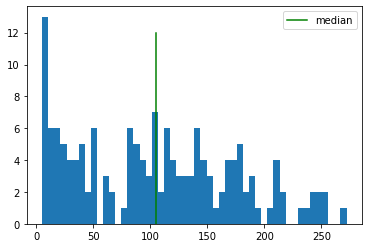

In [ ]:
y, x, _ = plt.hist(observation_at_least_5['max_days_alive'], bins=50)
y = np.arange(start=0, stop=y.max(), step=2)
x = np.random.choice([observation_at_least_5['max_days_alive'].median()], size=y.size)
plt.plot(x, y, color='green', label='median')
plt.legend()

Модель работает, потому что:

1.   Редко, когда когорта живет меньше, чем 5 дней
2.   Центральная тенденция (взята медиана, так как среднее будет больше из-за хвоста) времи жизни 100 дней (но взято 90 для устойчивости, так как вероятность прожить 90 дней куда выше, чем 100: это как со средняя продолжительность жизни в России - 72 года, уж куда вероятнее дожить до 50, чем до 72 (чего-то больно много, но гугл же не может врать :))

Именно поэтому можно в качестве подсчетов lvt использовать суммарные данные на 5-ый и 90-ый день.

Точность предсказания зависит от:


1.   Устойчивости времени жизни от 5 дней дней и 90 дней
2.   Количества юзеров в когорте (интерес к продукту): скажем, если юзеров в каждой новой когорте становится больше, а суммарно денег столько же - avg на юзера будет меньше.
3.   Количества приносимых денег каждым юзером (экономический фактор): скажем, если юзеров в каждой новой когорте в среднем столько же, а денег они дают больше, avg на юзера будет меньше

Качественные улучшения: помимо (точнее уже после) модификации коэффициента, мне все никак не давала покоя мысль применить регрессивную модель (в особенности после преобразования колонки ltv_90 через логарифм, где как раз логарифмическая "подошла бы" больше всего). В конце концов, k отражает степень чувствительности целевой переменной y (ltv_90) от x (ltv_5), классическая функция y=kx, меняй k, минимиризуй сумму квадратов ошибки, profit



До и после обработки выбросов.

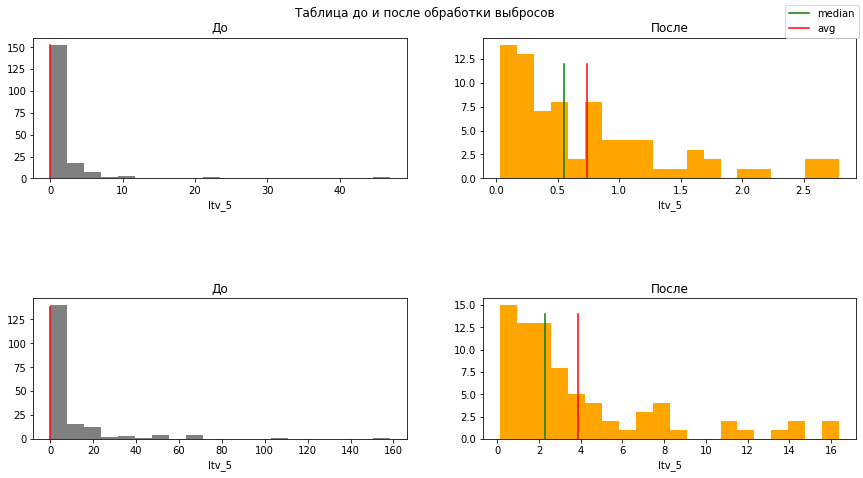

In [ ]:
#ЗАДАЧА на будущее - упростить вывод таблиц
#пока для наглядности ок (имхо)

figure = plt.figure() 
axes = figure.subplots(nrows=2, ncols=2)
figure.suptitle('Таблица до и после обработки выбросов',  x=1, y=1)

#BEFORE
#ltv_5
y, x, _ = axes[0][0].hist(table_before['ltv_5_per_user'], bins=20, color='grey')
y_before = np.arange(start=0, stop=y.max(), step=2)
x_before = np.random.choice(table_before['ltv_5_per_user_mean'], size=y_before.size)
axes[0][0].plot(x_before, y_before, color='red')
axes[0][0].set_title('До')
axes[0][0].set_xlabel("ltv_5")

#ltv_90
y, x, _ = axes[1][0].hist(table_before['ltv_90_per_user'], bins=20, color='grey')
y_before = np.arange(start=0, stop=y.max(), step=2)
x_before = np.random.choice(table_before['ltv_90_per_user_mean'], size=y_before.size)
axes[1][0].plot(x_before, y_before, color='red')
axes[1][0].set_title('До')
axes[1][0].set_xlabel("ltv_5")

#AFTER
#ltv_5
y, x, _ = axes[0][1].hist(table_after['ltv_5_per_user'], bins=20, color='orange')
y_after = np.arange(start=0, stop=y.max(), step=2)
x_after = np.random.choice(table_after['ltv_5_per_user_mean'], size=y_after.size)
axes[0][1].plot(x_after, y_after, color='green')
x_after = np.random.choice(table_after['ltv_5_per_user_avg'], size=y_after.size)
axes[0][1].plot(x_after, y_after, color='red')
axes[0][1].set_title('После')
axes[0][1].set_xlabel("ltv_5")

#ltv_90
y, x, _ = axes[1][1].hist(table_after['ltv_90_per_user'], bins=20, color='orange')
y_after = np.arange(start=0, stop=y.max(), step=2)
x_after = np.random.choice(table_after['ltv_90_per_user_mean'], size=y_after.size)
axes[1][1].plot(x_after, y_after, color='green', label='median')
x_after = np.random.choice(table_after['ltv_90_per_user_avg'], size=y_after.size)
axes[1][1].plot(x_after, y_after, color='red', label='avg')
axes[1][1].set_title('После')
axes[1][1].set_xlabel("ltv_5")

figure.tight_layout(pad=1.5)
plt.subplots_adjust(right=2, bottom=-0.5)

figure.legend()
plt.show()

#plt.hist(table_after['ltv_5_per_user'], bins=15)
#plt.plot([0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55], [0, 2, 4, 8, 10, 12, 14, 16])

Медиана в пост-обработке показывает центральную тенденцию лучше, чем среднее, так как на среднее слишком сильно влиет хвост. Поэтому она и была взята как ltv_avg_5 и ltv_avg_90 соотвественно в модифицированной версии коэффициента

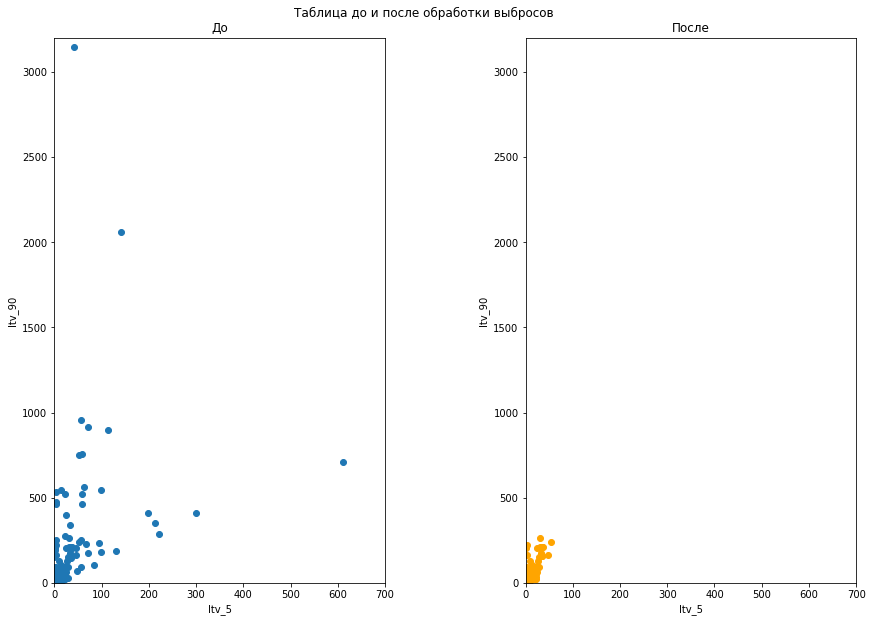

In [ ]:
figure = plt.figure() 
axes = figure.subplots(nrows=1, ncols=2)
figure.suptitle('Таблица до и после обработки выбросов',  x=1, y=1)

axes[0].scatter(table_before['ltv_5'], table_before['ltv_90'])
axes[0].set_title('До')
axes[0].set_xlabel("ltv_5")
axes[0].set_ylabel("ltv_90")
axes[0].set_ylabel("ltv_90")
axes[0].set_xlim(0, 700)
axes[0].set_ylim(0, 3200)

axes[1].scatter(table_after['ltv_5'], table_after['ltv_90'], color='orange')
axes[1].set_title('После')
axes[1].set_xlabel("ltv_5")
axes[1].set_ylabel("ltv_90")
axes[1].set_xlim(0, 700)
axes[1].set_ylim(0, 3200)

figure.tight_layout(pad=1.5)
plt.subplots_adjust(right=2, bottom=-1)
plt.show()

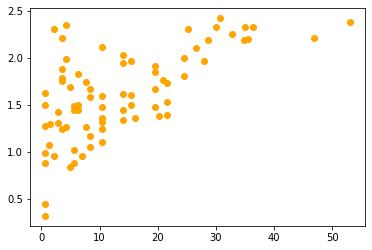

In [ ]:
#логарифмическое преобразование
table_after['ltv_90_log'] = np.log10(table_after['ltv_90'])
plt.scatter(table_after['ltv_5'] , table_after['ltv_90_log'], color='orange')